# Extract from all Docs
### Set up

In [229]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import DocumentAnalysisClient
import json
import openai
import os
import pandas as pd
from PyPDF4 import PdfFileWriter, PdfFileReader
import pdfplumber
from llama_index import SimpleDirectoryReader, VectorStoreIndex, ServiceContext
from llama_index.node_parser import SimpleNodeParser
from llama_index import Document

with open('../settings.json') as f:
    data = json.load(f)

# Set form recogniser client
credential = AzureKeyCredential(data["FORM_KEY"])
document_analysis_client = DocumentAnalysisClient(data["FORM_ENDPOINT"], credential)

# This example also requires an OpenAI API key
os.environ['OPENAI_API_KEY'] = data['OPENAI_API_KEY']
openai.api_key = os.environ['OPENAI_API_KEY']

In [230]:
import io

# OCR from base form recogniser
def base_form_recogniser(pdf_bytes: io.BytesIO) -> dict:
    document = pdf_bytes.getvalue()

    # Start the document analysis
    poller = document_analysis_client.begin_analyze_document("prebuilt-document", document, polling_interval=5)

    # Get the result
    result = poller.result()
    data = result.to_dict()
    return data

In [269]:
json_template = json.dumps({"Tests":[{
    "Test Type": "<FIT or LOT>",
    "Casing Shoe": "<Casing shoe size>",
    "TVD (m)": "TVD depth in meters",
    "MD (m)": "MD depth in meters",
    "Surface pressure (psi)": "<Surface pressure value>",
    "MW (sg)": "<MW value in sg>",
    "EMW (sg)": "<EMW value in sg>"
}]})

system = f"""
You are an assistant that given a text extracted using OCR from an End of Well Report will extract 'Formation Integrity Test' (FIT) and 'Leak Off Test' (LOT) results.
There can be multiple tests, report all of them.
Write your output as a JSON with an entry with the format {json_template} per each test you find.
If there is a field that you can not find, set it a null.
If the document has any kind of errors or is corrupted, add a field {{"errors": "<error description>"}}
If there is any additional information of feedback from the infromation extraction, add a {{"notes": "<additional-information>"}}
"""

In [232]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"Tests":[]}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        for page in pdf.pages:
            if page.search("FIT") or page.search("LOT"):
                output.addPage(inputpdf.pages[page.page_number])

    output_bytesio = io.BytesIO()
    output.write(output_bytesio)
    try: 
        extracted_text = base_form_recogniser(output_bytesio)
        print(file)
    except Exception as e:
        continue
    
    documents = [Document(text=extracted_text["content"])]

    node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
    service_context = ServiceContext.from_defaults(node_parser=node_parser)

    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    query_engine = index.as_query_engine()
    response = query_engine.query(system)
    print(response)
    for t in json.loads(response.response)["Tests"]:
        table["Tests"].append(t)

df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])


206-08-16.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "Not found", "TVD (m)": "Not found", "Surface pressure (psi)": "Not found", "MW (sg)": "Not found", "EMW (sg)": "Not found"}, {"Test Type": "LOT", "Casing Shoe": "Not found", "TVD (m)": "Not found", "Surface pressure (psi)": "Not found", "MW (sg)": "Not found", "EMW (sg)": "Not found"}]}
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "9 5/8", "TVD (m)": "1816", "Surface pressure (psi)": "965.0", "MW (sg)": "1.32", "EMW (sg)": "1.694"}]}
BHGE Integrated EOWR_204_20_L12.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "36x30-in.", "TVD (m)": "590.7", "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": null}, {"Test Type": "LOT", "Casing Shoe": null, "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": null}], "notes": "The FIT test is mentioned in the report with casing shoe size and TVD, but other parameters such as surface pressure, MW, and

In [233]:
df

,Test Type,Casing Shoe,TVD (m),Surface pressure (psi),MW (sg),EMW (sg)
0,FIT,Not found,Not found,Not found,Not found,Not found
1,LOT,Not found,Not found,Not found,Not found,Not found
2,FIT,9 5/8,1816,965.0,1.32,1.694
3,FIT,36x30-in.,590.7,None,None,None
4,LOT,None,None,None,None,None
5,FIT,"13.3/8""",Unknown,Unknown,Unknown,Unknown
6,LOT,Unknown,Unknown,Unknown,Unknown,Unknown
7,FIT,"20""",595,420,1.15,None
8,LOT,"13-3/8""",None,None,None,None
9,FIT,"13-3/8""",1431,264,1.53,1.686


## Better Filtering

In [234]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"Tests":[]}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        print(file)
        for page in pdf.pages:
            if page.search("FIT") and page.search("sg") and page.search("EMW"):
                print(page)

206-08-16.pdf


<Page:125>
<Page:131>
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
<Page:5>
<Page:13>
<Page:53>
<Page:54>
BHGE Integrated EOWR_204_20_L12.pdf
<Page:28>
<Page:29>
<Page:31>
Clair A21 EOWR.pdf
<Page:10>
<Page:21>
<Page:23>
Clair Ridge S2U3P3 EOWR - Drilling.pdf
<Page:57>
<Page:110>
ClairCIW25_Drilling_EOWR_Rev1_FINAL.pdf
<Page:40>
<Page:43>
<Page:44>
<Page:85>


In [235]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"EoWR": [], "Tests": []}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        for page in pdf.pages:
            if page.search("FIT") and page.search("sg") and page.search("EMW"):
                output.addPage(inputpdf.pages[page.page_number])

    output_bytesio = io.BytesIO()
    output.write(output_bytesio)
    try:
        extracted_text = base_form_recogniser(output_bytesio)
        print(file)
    except Exception as e:
        continue

    documents = [Document(text=extracted_text["content"])]

    node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
    service_context = ServiceContext.from_defaults(node_parser=node_parser)

    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    query_engine = index.as_query_engine()
    response = query_engine.query(system)
    print(response)
    for t in json.loads(response.response)["Tests"]:
        table["EoWR"].append(file)  # Add the file name to the "EoWR" column
        table["Tests"].append(t)

df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])
df.insert(0, 'EoWR', table['EoWR'])

206-08-16.pdf
{"Tests": [{"Test Type": "Formation Integrity Test", "Casing Shoe": "13 3/8\"", "TVD (m)": "132", "Surface pressure (psi)": "null", "MW (sg)": "null", "EMW (sg)": "null"}, {"Test Type": "Leak Off Test", "Casing Shoe": "13 3/8\"", "TVD (m)": "null", "Surface pressure (psi)": "1220", "MW (sg)": "1.32", "EMW (sg)": "2.03"}]}
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "9 5/8", "TVD (m)": "1816", "Surface pressure (psi)": "965", "MW (sg)": "1.32", "EMW (sg)": "1.694"}, {"Test Type": "LOT", "Casing Shoe": "9 5/8", "TVD (m)": "1816", "Surface pressure (psi)": "965", "MW (sg)": "1.32", "EMW (sg)": "1.694"}]}
BHGE Integrated EOWR_204_20_L12.pdf
{"Tests": [{"Test Type": "Formation Integrity Test", "Casing Shoe": null, "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.45sg"}]}
Clair A21 EOWR.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "13.3/8\"", "TVD (m)": "Unknown", "Surface pressure (psi)

In [242]:
df

,EoWR,Test Type,Casing Shoe,TVD (m),Surface pressure (psi),MW (sg),EMW (sg)
0,206-08-16.pdf,Formation Integrity Test,"13 3/8""",132,null,null,null
1,206-08-16.pdf,Leak Off Test,"13 3/8""",null,1220,1.32,2.03
2,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,FIT,9 5/8,1816,965,1.32,1.694
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9 5/8,1816,965,1.32,1.694
4,BHGE Integrated EOWR_204_20_L12.pdf,Formation Integrity Test,None,None,None,None,1.45sg
5,Clair A21 EOWR.pdf,FIT,"13.3/8""",Unknown,Unknown,Unknown,Unknown
6,Clair A21 EOWR.pdf,LOT,Unknown,Unknown,Unknown,Unknown,Unknown
7,Clair Ridge S2U3P3 EOWR - Drilling.pdf,Formation Integrity Test,None,None,4500,None,None
8,Clair Ridge S2U3P3 EOWR - Drilling.pdf,Leak Off Test,None,None,None,None,None
9,ClairCIW25_Drilling_EOWR_Rev1_FINAL.pdf,Formation Integrity Test,"13-3/8""",1428,264,1.53,1.686


# Performance Study

In [345]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [367]:
from difflib import SequenceMatcher
from promptimize import evals

# Define a function to extract numbers, keeping dots, and format with three decimal places
def extract_numbers(input_string):
    if isinstance(input_string, str):
        # Use regular expression to keep digits and dots
        extracted = re.sub(r'[^\d.]', '', input_string)
        try:
            # Format the extracted value to three decimal places
            formatted = "{:.3f}".format(float(extracted))
            return formatted
        except ValueError:
            return ''  # Return an empty string for invalid numbers
    else:
        return ''  # Return an empty string for non-string values
    
def sequence_matcher(a, b):
    return SequenceMatcher(None, a, b).ratio()

def jaccard_similarity(a, b):
    intersection = len(set(a).intersection(set(b)))
    union = len(set(a).union(set(b)))
    return intersection / union

In [327]:
def performance_plot(df, plot_type="sequence", size_x=14, size_y=6):
    type_text = plot_type + '_'
    if plot_type == "sequence":
        for col in df.columns:
            if col.startswith('label_'):
                label_col = col.replace('label_', '')
                seq_col = col.replace('label_', type_text)
                df[seq_col] = df.apply(lambda row: sequence_matcher(str(row[col]), str(row[label_col])), axis=1)
    elif plot_type == "jaccard":
        type_text = plot_type + '_'
        for col in df.columns:
            if col.startswith('label_'):
                label_col = col.replace('label_', '')
                seq_col = col.replace('label_', type_text)
                df[seq_col] = df.apply(lambda row: jaccard_similarity(str(row[col]), str(row[label_col])), axis=1)
    elif plot_type == "percentage":
        type_text = plot_type + '_'
        for col in df.columns:
            if col.startswith('label_'):
                label_col = col.replace('label_', '')
                seq_col = col.replace('label_', type_text)
                df[seq_col] = df.apply(lambda row: evals.percentage_of_words(str(row[col]), str(row[label_col])), axis=1)
    else:
        raise ValueError("Performance types should be sequence or jaccard")

    # Select only columns with the prefix "plot type_"
    plot_type_columns = df.filter(like=f'{plot_type}_')

    # Keep the first two columns
    first_two_columns = df.iloc[:, :2]

    # Concatenate the first two columns and the selected plot type columns
    plot_type_columns = pd.concat([first_two_columns, plot_type_columns], axis=1)

    # Set the index and columns for the heatmap
    plot_type_columns.set_index(['EoWR', 'Test Type'], inplace=True)

    # Create a heatmap using Seaborn with horizontal y-axis labels
    plt.figure(figsize=(size_x, size_y))
    ax = sns.heatmap(plot_type_columns, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': f'{plot_type} Value'})
    plt.title(f'Heatmap of {plot_type} values')

    # Rotate the x-axis labels to a 20-degree angle
    plt.xticks(rotation=15)

    # Rotate the y-axis labels to be horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.show()
    return None

In [250]:
labels = pd.read_excel("../data/labels/labels.xlsx")
prefix = "label_"
# Add the prefix to all column names except the first one
labels.columns = [*labels.columns[:2]] + [prefix + col for col in labels.columns[2:]]
labels

,EoWR,Casing Shoe,label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,20,LOT,620.0,620.0,115.0,1.230
1,206-08-16.pdf,13-3/8,LOT,1180.0,1180.0,1220.0,2.030
2,206-08-16.pdf,9-5/8,FIT,1550.0,1550.0,683.0,1.520
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,20,LOT,536.0,536.0,84.0,1.260
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,13-3/8,FIT,1119.0,1149.0,328.0,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,9-5/8,LOT,1816.0,2081.0,965.0,1.694
6,BHGE Integrated EOWR_204_20_L12.pdf,9-5/8,FIT,1772.7,1798.0,NaN,1.450
7,Clair A21 EOWR.pdf,12.1/4,FIT,1131.0,1275.0,NaN,1.720
8,Clair Ridge S2U3P3 EOWR - Drilling.pdf,20,LOT,NaN,NaN,NaN,1.170
9,Clair Ridge S2U3P3 EOWR - Drilling.pdf,13-3/8,FIT,1171.0,1075.0,NaN,1.630


Let's see the performance so far

Not a single correct match

In [251]:
merge_condition = ["EoWR", "Casing Shoe"]
result_df = df.merge(labels, on=merge_condition, how="left").dropna()
result_df

,EoWR,Test Type,Casing Shoe,TVD (m),Surface pressure (psi),MW (sg),EMW (sg),label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)


## GPT 4

In [253]:
from llama_index import LLMPredictor
from langchain.chat_models import ChatOpenAI

In [254]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"EoWR": [], "Tests": []}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        for page in pdf.pages:
            if page.search("FIT") and page.search("sg") and page.search("EMW"):
                output.addPage(inputpdf.pages[page.page_number])

    output_bytesio = io.BytesIO()
    output.write(output_bytesio)
    try:
        extracted_text = base_form_recogniser(output_bytesio)
        print(file)
    except Exception as e:
        continue

    documents = [Document(text=extracted_text["content"])]

    node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
    llm_predictor = LLMPredictor(llm=ChatOpenAI(
        temperature=0.2,
        model_name="gpt-4"
    ))
    service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    query_engine = index.as_query_engine()
    response = query_engine.query(system)
    print(response)
    for t in json.loads(response.response)["Tests"]:
        table["EoWR"].append(file)  # Add the file name to the "EoWR" column
        table["Tests"].append(t)

df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])
df.insert(0, 'EoWR', table['EoWR'])

206-08-16.pdf
{"Tests": [{"Test Type": "LOT", "Casing Shoe": "13 3/8\"", "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": "1.32", "EMW (sg)": "2.03"}]}
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
{"Tests": [
    {"Test Type": "FIT", "Casing Shoe": "20\"", "TVD (m)": "532", "Surface pressure (psi)": "965", "MW (sg)": "1.32", "EMW (sg)": "1.694"},
    {"Test Type": "LOT", "Casing Shoe": "9 5/8\"", "TVD (m)": "1816", "Surface pressure (psi)": "965", "MW (sg)": "1.32", "EMW (sg)": "1.694"},
    {"Test Type": "LOT", "Casing Shoe": "9 5/8\"", "TVD (m)": "1816", "Surface pressure (psi)": "965", "MW (sg)": "1.32", "EMW (sg)": "1.694"}
]}
BHGE Integrated EOWR_204_20_L12.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": null, "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": "1.24", "EMW (sg)": "1.45"}], "errors": null, "notes": "The document does not provide information on 'Leak Off Test' (LOT) results, casing shoe size, TVD in meters, and surface pressure in psi fo

In [255]:
df

,EoWR,Test Type,Casing Shoe,TVD (m),Surface pressure (psi),MW (sg),EMW (sg)
0,206-08-16.pdf,LOT,"13 3/8""",None,None,1.32,2.03
1,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,FIT,"20""",532,965,1.32,1.694
2,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9 5/8""",1816,965,1.32,1.694
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9 5/8""",1816,965,1.32,1.694
4,BHGE Integrated EOWR_204_20_L12.pdf,FIT,None,None,None,1.24,1.45
5,Clair Ridge S2U3P3 EOWR - Drilling.pdf,FIT,None,None,None,1.52,None
6,ClairCIW25_Drilling_EOWR_Rev1_FINAL.pdf,FIT,"13-3/8""",None,264,1.53,1.686


In [256]:
labels

,EoWR,Casing Shoe,label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,20,LOT,620.0,620.0,115.0,1.230
1,206-08-16.pdf,13-3/8,LOT,1180.0,1180.0,1220.0,2.030
2,206-08-16.pdf,9-5/8,FIT,1550.0,1550.0,683.0,1.520
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,20,LOT,536.0,536.0,84.0,1.260
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,13-3/8,FIT,1119.0,1149.0,328.0,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,9-5/8,LOT,1816.0,2081.0,965.0,1.694
6,BHGE Integrated EOWR_204_20_L12.pdf,9-5/8,FIT,1772.7,1798.0,NaN,1.450
7,Clair A21 EOWR.pdf,12.1/4,FIT,1131.0,1275.0,NaN,1.720
8,Clair Ridge S2U3P3 EOWR - Drilling.pdf,20,LOT,NaN,NaN,NaN,1.170
9,Clair Ridge S2U3P3 EOWR - Drilling.pdf,13-3/8,FIT,1171.0,1075.0,NaN,1.630


In [262]:
merge_condition = ["EoWR", "Casing Shoe"]
result_df = df.merge(labels, on=merge_condition, how="left").dropna()
result_df

,EoWR,Test Type,Casing Shoe,TVD (m),Surface pressure (psi),MW (sg),EMW (sg),label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)


### Refined output prompt

In [271]:
json_template = json.dumps({"Tests":[{
    "Test Type": "<Leak Off or Formation Integrity Tests. Format should be FIT or LOT>",
    "Casing Shoe": "<Casing shoe size associated. Avoid spaces, use '-' instead>",
    "TVD (m)": "TVD depth in meters",
    "MD (m)": "MD depth in meters",
    "Surface pressure (psi)": "<Surface pressure value>",
    "MW (sg)": "<MW value in sg>",
    "EMW (sg)": "<EMW value in sg>"
}]})

system = f"""
You are an assistant that given a text extracted using OCR from an End of Well Report will extract 'Formation Integrity Test' (FIT) and 'Leak Off Test' (LOT) results.
There can be multiple tests, report all of them.
Write your output as a JSON with an entry with the format {json_template} per each test you find.
If there is a field that you can not find, set it a null.
If there is any additional information of feedback from the infromation extraction, add a {{"notes": "<additional-information>"}}
"""

In [272]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"EoWR": [], "Tests": []}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        for page in pdf.pages:
            if page.search("FIT") and page.search("sg") and page.search("EMW"):
                output.addPage(inputpdf.pages[page.page_number])

    output_bytesio = io.BytesIO()
    output.write(output_bytesio)
    try:
        extracted_text = base_form_recogniser(output_bytesio)
        print(file)
    except Exception as e:
        continue

    documents = [Document(text=extracted_text["content"])]

    node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
    llm_predictor = LLMPredictor(llm=ChatOpenAI(
        temperature=0,
        model_name="gpt-4"
    ))
    service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    query_engine = index.as_query_engine()
    response = query_engine.query(system)
    print(response)
    try:
        for t in json.loads(response.response)["Tests"]:
            table["EoWR"].append(file)  # Add the file name to the "EoWR" column
            table["Tests"].append(t)
    except Exception as e:
        continue
    
df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])
df.insert(0, 'EoWR', table['EoWR'])
df

206-08-16.pdf
{"Tests": [
  {"Test Type": "LOT", 
   "Casing Shoe": "13-3/8", 
   "TVD (m)": null, 
   "MD (m)": null, 
   "Surface pressure (psi)": null, 
   "MW (sg)": "1.32", 
   "EMW (sg)": "2.03"},
  {"Test Type": "Pressure test", 
   "Casing Shoe": "13-3/8", 
   "TVD (m)": null, 
   "MD (m)": null, 
   "Surface pressure (psi)": "2600", 
   "MW (sg)": "1.20", 
   "EMW (sg)": null}
  ],
  "notes": "The information provided does not include all the required fields for each test. Missing fields have been set to null."}
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
{"Tests": [
  {"Test Type": "FIT", 
   "Casing Shoe": "20\"", 
   "TVD (m)": "532", 
   "MD (m)": "532", 
   "Surface pressure (psi)": null, 
   "MW (sg)": null, 
   "EMW (sg)": "1.26"}, 
  {"Test Type": "LOT", 
   "Casing Shoe": "9-5/8\"", 
   "TVD (m)": "1816", 
   "MD (m)": "2081", 
   "Surface pressure (psi)": "965", 
   "MW (sg)": "1.32", 
   "EMW (sg)": "1.694"}, 
  {"Test Type": "LOT", 
   "Casing Shoe": "9-5/8\

,EoWR,Test Type,Casing Shoe,TVD (m),MD (m),Surface pressure (psi),MW (sg),EMW (sg)
0,206-08-16.pdf,LOT,13-3/8,None,None,None,1.32,2.03
1,206-08-16.pdf,Pressure test,13-3/8,None,None,2600,1.20,None
2,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,FIT,"20""",532,532,None,None,1.26
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694
5,BHGE Integrated EOWR_204_20_L12.pdf,FIT,None,None,1750,None,1.24,1.45
6,Clair Ridge S2U3P3 EOWR - Drilling.pdf,FIT,None,None,None,None,1.52,None
7,ClairCIW25_Drilling_EOWR_Rev1_FINAL.pdf,FIT,13-3/8,None,1472,264,1.53,1.686


In [284]:
merge_condition = ["EoWR"]
result_df = df.merge(labels.drop("Casing Shoe", axis=1), on=merge_condition, how="left").dropna()
result_df

,EoWR,Test Type,Casing Shoe,TVD (m),MD (m),Surface pressure (psi),MW (sg),EMW (sg),label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
9,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694,LOT,536.0,536.0,84.0,1.260
10,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694,FIT,1119.0,1149.0,328.0,1.756
11,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694,LOT,1816.0,2081.0,965.0,1.694
12,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694,LOT,536.0,536.0,84.0,1.260
13,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694,FIT,1119.0,1149.0,328.0,1.756
14,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,"9-5/8""",1816,2081,965,1.32,1.694,LOT,1816.0,2081.0,965.0,1.694


In [287]:
savedhere = result_df.copy()

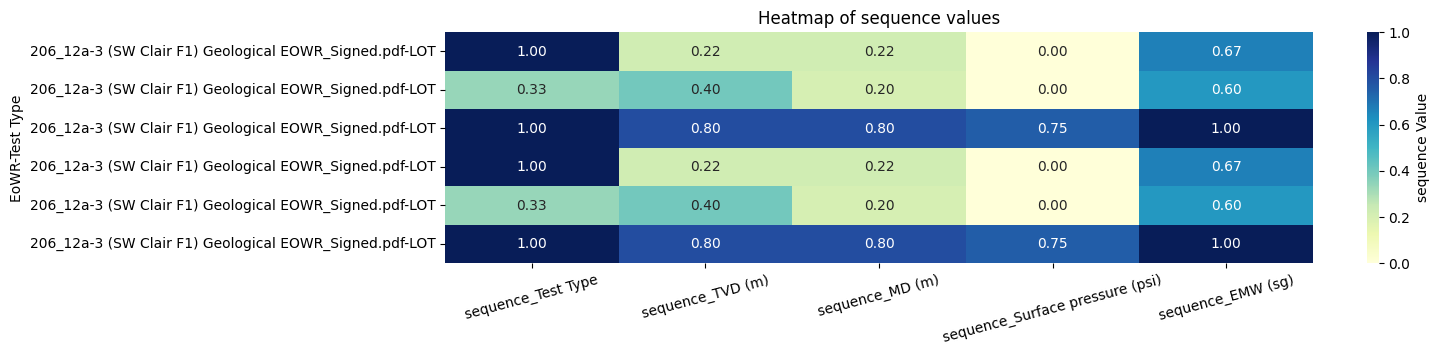

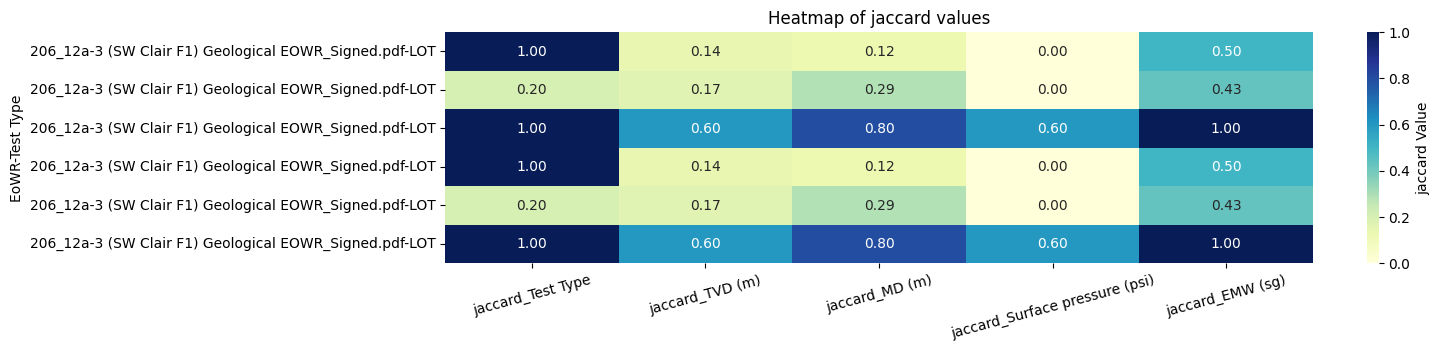

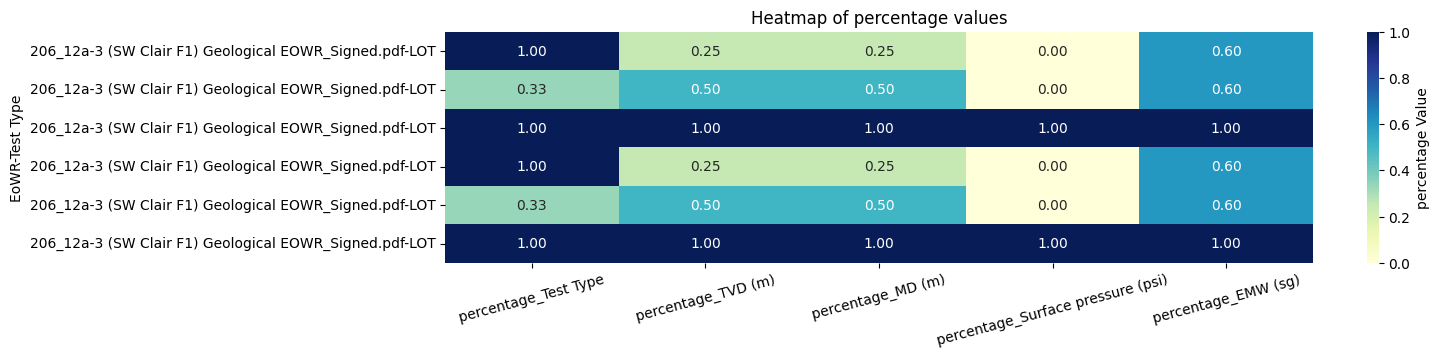

In [329]:
performance_plot(savedhere, size_y=3)
performance_plot(savedhere, "jaccard", size_y=3)
performance_plot(savedhere, "percentage", size_y=3)

### Filtering Issue solved

In [289]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"EoWR": [], "Tests": []}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        for page in pdf.pages:
            if page.search("FIT") and page.search("sg") and page.search("EMW"):
                output.addPage(inputpdf.pages[page.page_number-1])

    output_bytesio = io.BytesIO()
    output.write(output_bytesio)
    try:
        extracted_text = base_form_recogniser(output_bytesio)
        print(file)
    except Exception as e:
        continue

    documents = [Document(text=extracted_text["content"])]

    node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
    llm_predictor = LLMPredictor(llm=ChatOpenAI(
        temperature=0,
        model_name="gpt-4"
    ))
    service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    query_engine = index.as_query_engine()
    response = query_engine.query(system)
    print(response)
    try:
        for t in json.loads(response.response)["Tests"]:
            table["EoWR"].append(file)  # Add the file name to the "EoWR" column
            table["Tests"].append(t)
    except Exception as e:
        continue
    
df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])
df.insert(0, 'EoWR', table['EoWR'])
df

206-08-16.pdf
{"Tests": [
  {"Test Type": "LOT", 
   "Casing Shoe": "20", 
   "TVD (m)": "620", 
   "MD (m)": "620", 
   "Surface pressure (psi)": "115", 
   "MW (sg)": "1.10sg", 
   "EMW (sg)": "1.23sg"},

  {"Test Type": "LOT", 
   "Casing Shoe": "13-3/8", 
   "TVD (m)": "1180", 
   "MD (m)": "1180", 
   "Surface pressure (psi)": "1220", 
   "MW (sg)": "1.32sg", 
   "EMW (sg)": "2.03sg"},

  {"Test Type": "FIT", 
   "Casing Shoe": "9-5/8", 
   "TVD (m)": "1550", 
   "MD (m)": "1550", 
   "Surface pressure (psi)": "683psi", 
   "MW (sg)": "1.21sg", 
   "EMW (sg)": "1.52sg"}
]}
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
{
"Tests": [
{
"Test Type": "LOT",
"Casing Shoe": "20",
"TVD (m)": "536",
"MD (m)": "536",
"Surface pressure (psi)": "84.0",
"MW (sg)": "1.15",
"EMW (sg)": "1.26"
},
{
"Test Type": "FIT",
"Casing Shoe": "13-3/8",
"TVD (m)": "1119",
"MD (m)": "1149",
"Surface pressure (psi)": "328.0",
"MW (sg)": "1.55",
"EMW (sg)": "1.756"
},
{
"Test Type": "LOT",
"Casing Shoe": 

,EoWR,Test Type,Casing Shoe,TVD (m),MD (m),Surface pressure (psi),MW (sg),EMW (sg)
0,206-08-16.pdf,LOT,20,620,620,115,1.10sg,1.23sg
1,206-08-16.pdf,LOT,13-3/8,1180,1180,1220,1.32sg,2.03sg
2,206-08-16.pdf,FIT,9-5/8,1550,1550,683psi,1.21sg,1.52sg
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,20,536,536,84.0,1.15,1.26
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,FIT,13-3/8,1119,1149,328.0,1.55,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9-5/8,1816,None,965.0,1.32,1.694
6,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9-5/8,1816,2081,965.0,1.32,1.694
7,BHGE Integrated EOWR_204_20_L12.pdf,FIT,13-3/8-in,1772.7,1798,None,1.24,1.45
8,Clair A21 EOWR.pdf,FIT,12.1/4,None,None,None,None,1.72
9,Clair A21 EOWR.pdf,FIT,None,None,None,None,None,1.71


In [313]:
labels

,EoWR,Casing Shoe,label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,20,LOT,620.0,620.0,115.0,1.230
1,206-08-16.pdf,13-3/8,LOT,1180.0,1180.0,1220.0,2.030
2,206-08-16.pdf,9-5/8,FIT,1550.0,1550.0,683.0,1.520
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,20,LOT,536.0,536.0,84.0,1.260
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,13-3/8,FIT,1119.0,1149.0,328.0,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,9-5/8,LOT,1816.0,2081.0,965.0,1.694
6,BHGE Integrated EOWR_204_20_L12.pdf,9-5/8,FIT,1772.7,1798.0,NaN,1.450
7,Clair A21 EOWR.pdf,12.1/4,FIT,1131.0,1275.0,NaN,1.720
8,Clair Ridge S2U3P3 EOWR - Drilling.pdf,20,LOT,NaN,NaN,NaN,1.170
9,Clair Ridge S2U3P3 EOWR - Drilling.pdf,13-3/8,FIT,1171.0,1075.0,NaN,1.630


In [330]:
merge_condition = ["EoWR", "Casing Shoe"]
df2 = df.copy()
result_df = df2.merge(labels, on=merge_condition, how="left")

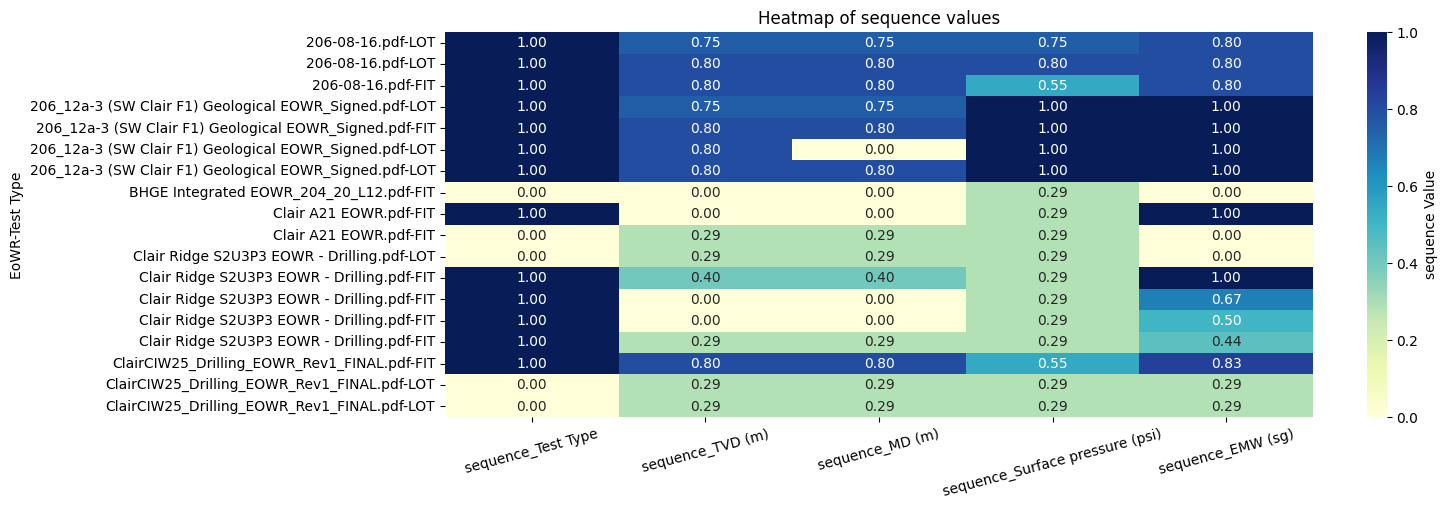

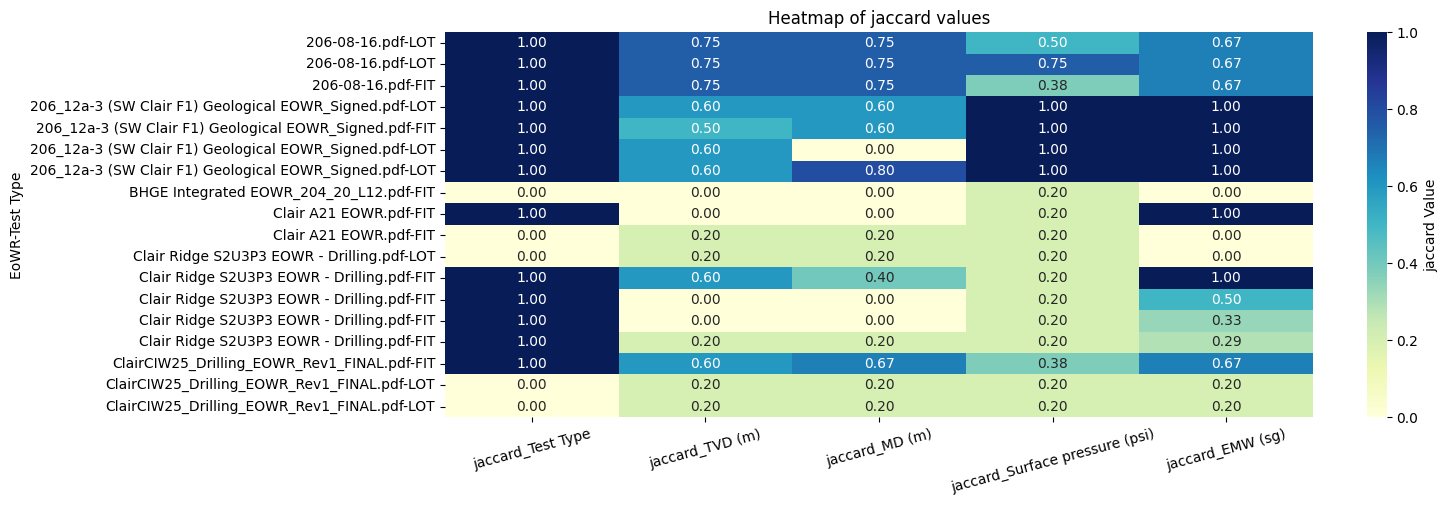

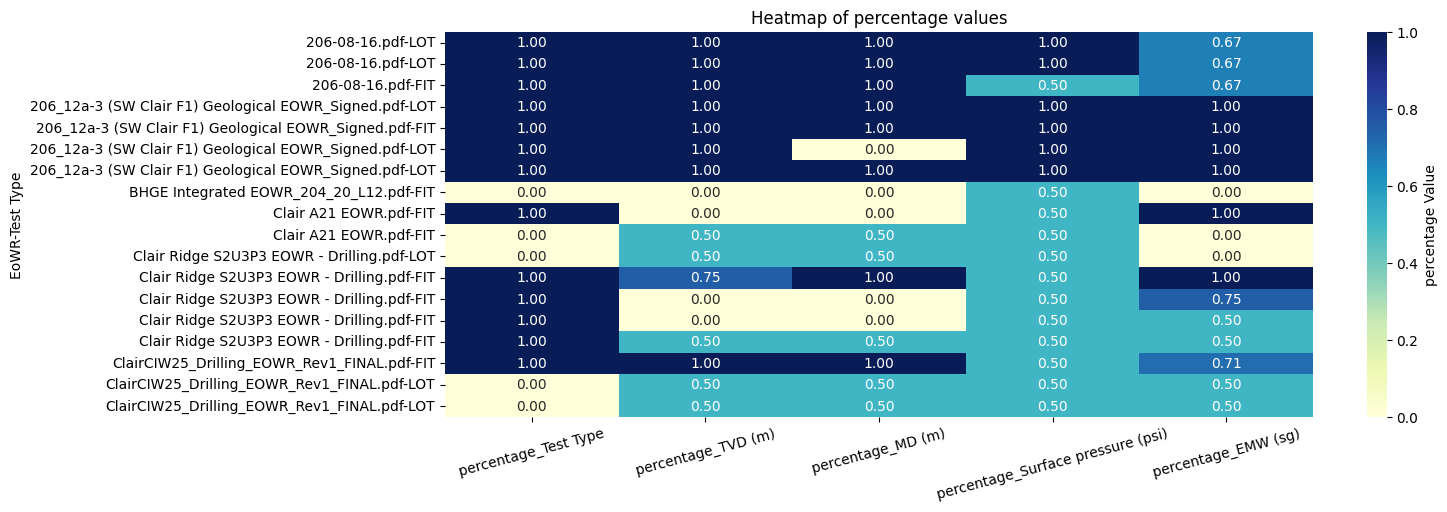

In [335]:
performance_plot(result_df, size_y=5)
performance_plot(result_df, "jaccard", size_y=5)
performance_plot(result_df, "percentage",  size_y=5)

# workbench

In [336]:
json_template = json.dumps({"Tests":[{
    "Test Type": "<Leak Off or Formation Integrity Tests. Format should be FIT or LOT>",
    "Casing Shoe": "<Casing shoe size associated. Avoid spaces, use '-' instead>",
    "TVD (m)": "TVD depth in meters",
    "MD (m)": "MD depth in meters",
    "Surface pressure (psi)": "<Surface pressure value>",
    "MW (sg)": "<MW value in sg>",
    "EMW (sg)": "<EMW value in sg>"
}]})

system = f"""
You are an assistant that given a text extracted using OCR from an End of Well Report will extract 'Formation Integrity Test' (FIT) and 'Leak Off Test' (LOT) results.
There can be multiple tests, report all of them.
Write your output as a JSON with an entry with the format {json_template} per each test you find.
If there is a field that you can not find, set it a null.
If there is any additional information of feedback from the infromation extraction, add a {{"notes": "<additional-information>"}}
"""

## 206-08-16.pdf

In [353]:
path = '../data/EoWR'
files = os.listdir(path)

file = files[0]

ewr = os.path.join(path, file)
inputpdf = PdfFileReader(open(ewr, "rb"))
output = PdfFileWriter()
relevant_text = ""

with pdfplumber.open(ewr) as pdf:
    for page in pdf.pages:
        if page.search("FIT") and page.search("sg") and page.search("EMW"):
            print(page)
            output.addPage(inputpdf.pages[page.page_number-1])

output_bytesio = io.BytesIO()
output.write(output_bytesio)

extracted_text = base_form_recogniser(output_bytesio)
print(file)


documents = [Document(text=extracted_text["content"])]

node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
llm_predictor = LLMPredictor(llm=ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4"
))
service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

index = VectorStoreIndex.from_documents(documents, service_context=service_context)
query_engine = index.as_query_engine()
response = query_engine.query(system)

table = {"EoWR": [], "Tests": []}
for t in json.loads(response.response)["Tests"]:
    table["EoWR"].append(file)  # Add the file name to the "EoWR" column
    table["Tests"].append(t)
df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])
df.insert(0, 'EoWR', table['EoWR'])
df["EMW (sg)"] = df['EMW (sg)'].apply(extract_numbers)


<Page:125>
<Page:131>
206-08-16.pdf


In [354]:
labels[labels['EoWR'] == "206-08-16.pdf"]

,EoWR,Casing Shoe,label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,20,LOT,620.0,620.0,115.0,1.23
1,206-08-16.pdf,13-3/8,LOT,1180.0,1180.0,1220.0,2.03
2,206-08-16.pdf,9-5/8,FIT,1550.0,1550.0,683.0,1.52


In [355]:
merge_condition = ["EoWR", "Casing Shoe"]
result_df = df.merge(labels, on=merge_condition, how="left").dropna()
result_df

,EoWR,Test Type,Casing Shoe,TVD (m),MD (m),Surface pressure (psi),MW (sg),EMW (sg),label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,LOT,20,620,620,115,1.10sg,1.23,LOT,620.0,620.0,115.0,1.23
1,206-08-16.pdf,LOT,13-3/8,1180,1180,1220,1.32sg,2.03,LOT,1180.0,1180.0,1220.0,2.03
2,206-08-16.pdf,FIT,9-5/8,1550,1550,683psi,1.21sg,1.52,FIT,1550.0,1550.0,683.0,1.52


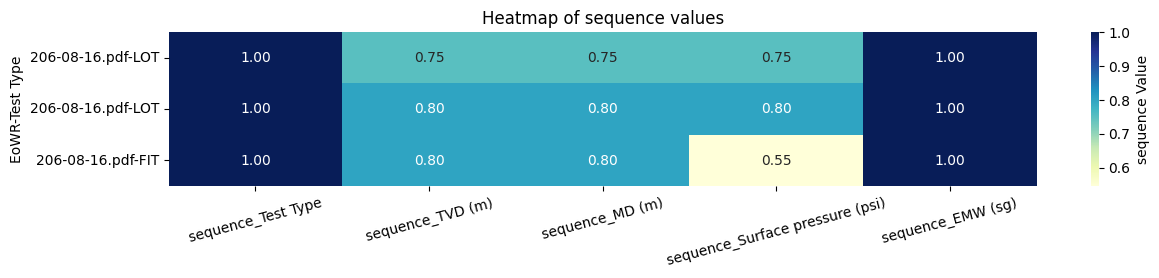

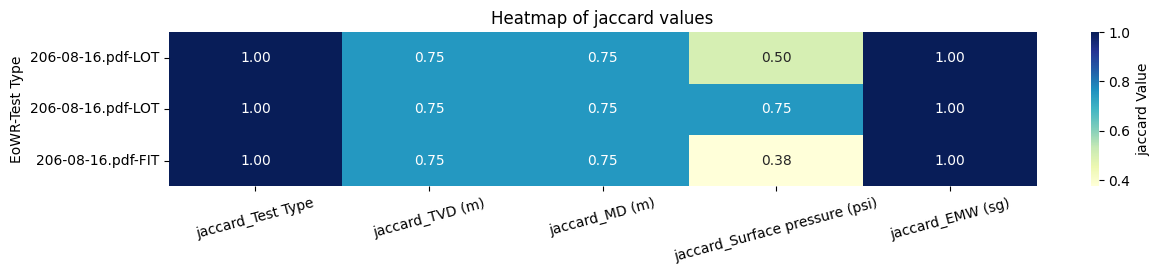

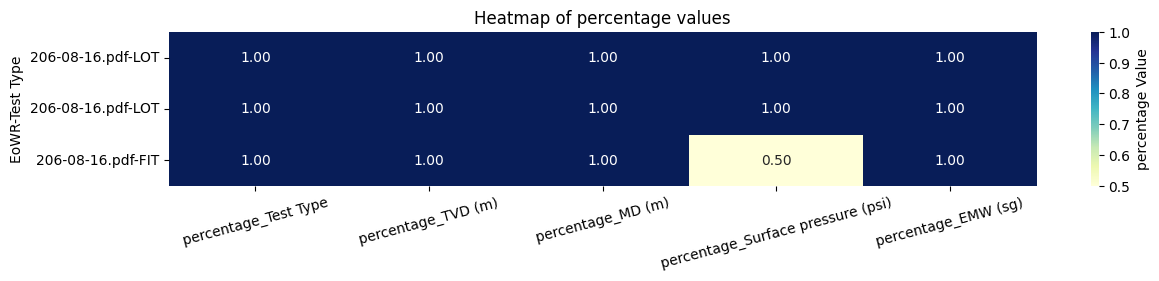

In [356]:
performance_plot(result_df, size_y=2)
performance_plot(result_df, "jaccard", size_y=2)
performance_plot(result_df, "percentage", size_y=2)

In [70]:
path = '../data/EoWR'
files = os.listdir(path)

file = files[1]

ewr = os.path.join(path, file)
inputpdf = PdfFileReader(open(ewr, "rb"))
output = PdfFileWriter()
relevant_text = ""

with pdfplumber.open(ewr) as pdf:
    for page in pdf.pages:
        if page.search("FIT") and page.search("sg") and page.search("EMW"):
            print(page)
            output.addPage(inputpdf.pages[page.page_number-1])

output_bytesio = io.BytesIO()
output.write(output_bytesio)

extracted_text = base_form_recogniser(output_bytesio)
print(file)


documents = [Document(text=extracted_text["content"])]

node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
llm_predictor = LLMPredictor(llm=ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4"
))
service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

index = VectorStoreIndex.from_documents(documents, service_context=service_context)
query_engine = index.as_query_engine()
response = query_engine.query(system)
print(response)

<Page:5>
<Page:13>
<Page:53>
<Page:54>
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf
{
"Tests": [
{
"Test Type": "LOT",
"Casing Shoe": "20",
"TVD (m)": "536",
"Surface pressure (psi)": "84.0",
"MW (sg)": "1.15",
"EMW (sg)": "1.26"
},
{
"Test Type": "FIT",
"Casing Shoe": "13-3/8",
"TVD (m)": "1119",
"Surface pressure (psi)": "328.0",
"MW (sg)": "1.55",
"EMW (sg)": "1.756"
},
{
"Test Type": "LOT",
"Casing Shoe": "9-5/8",
"TVD (m)": "1816",
"Surface pressure (psi)": "965.0",
"MW (sg)": "1.32",
"EMW (sg)": "1.694"
},
{
"Test Type": "LOT",
"Casing Shoe": "9-5/8",
"TVD (m)": "1816",
"Surface pressure (psi)": "965.0",
"MW (sg)": "1.32",
"EMW (sg)": "1.694"
}
],
"notes": "The first LOT at the 9-5/8\" shoe at 1816m TVD showed a decline in pressure from 1230psi to 960psi, indicating that the formation may have been broken down. A second test was carried out at the same location, confirming the fracture pressure from the first LOT as 965psi."
}


In [71]:
path = '../data/EoWR'
files = os.listdir(path)

file = files[2]

ewr = os.path.join(path, file)
inputpdf = PdfFileReader(open(ewr, "rb"))
output = PdfFileWriter()
relevant_text = ""

with pdfplumber.open(ewr) as pdf:
    for page in pdf.pages:
        if page.search("FIT") and page.search("sg") and page.search("EMW"):
            print(page)
            output.addPage(inputpdf.pages[page.page_number-1])

output_bytesio = io.BytesIO()
output.write(output_bytesio)

extracted_text = base_form_recogniser(output_bytesio)
print(file)


documents = [Document(text=extracted_text["content"])]

node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
llm_predictor = LLMPredictor(llm=ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4"
))
service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

index = VectorStoreIndex.from_documents(documents, service_context=service_context)
query_engine = index.as_query_engine()
response = query_engine.query(system)
print(response)

<Page:28>
<Page:29>
<Page:31>
BHGE Integrated EOWR_204_20_L12.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "13-3/8-in", "TVD (m)": "1772.7", "Surface pressure (psi)": null, "MW (sg)": "1.24", "EMW (sg)": "1.45"}], "notes": "The report does not provide information on the surface pressure for the FIT. Also, no LOT results were found in the provided context."}


In [72]:
path = '../data/EoWR'
files = os.listdir(path)

file = files[3]

ewr = os.path.join(path, file)
inputpdf = PdfFileReader(open(ewr, "rb"))
output = PdfFileWriter()
relevant_text = ""

with pdfplumber.open(ewr) as pdf:
    for page in pdf.pages:
        if page.search("FIT") and page.search("sg") and page.search("EMW"):
            print(page)
            output.addPage(inputpdf.pages[page.page_number-1])

output_bytesio = io.BytesIO()
output.write(output_bytesio)

extracted_text = base_form_recogniser(output_bytesio)
print(file)


documents = [Document(text=extracted_text["content"])]

node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
llm_predictor = LLMPredictor(llm=ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4"
))
service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

index = VectorStoreIndex.from_documents(documents, service_context=service_context)
query_engine = index.as_query_engine()
response = query_engine.query(system)
print(response)

<Page:10>
<Page:21>
<Page:23>
Clair A21 EOWR.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "32", "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.72"}, {"Test Type": "FIT", "Casing Shoe": "12.1/4", "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.72"}, {"Test Type": "FIT", "Casing Shoe": null, "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.71"}], "notes": "The context does not provide information on TVD, surface pressure, or MW for any of the tests. Also, the casing shoe size for the third test is not provided."}


In [73]:
path = '../data/EoWR'
files = os.listdir(path)

file = files[4]

ewr = os.path.join(path, file)
inputpdf = PdfFileReader(open(ewr, "rb"))
output = PdfFileWriter()
relevant_text = ""

with pdfplumber.open(ewr) as pdf:
    for page in pdf.pages:
        if page.search("FIT") and page.search("sg") and page.search("EMW"):
            print(page)
            output.addPage(inputpdf.pages[page.page_number-1])

output_bytesio = io.BytesIO()
output.write(output_bytesio)

extracted_text = base_form_recogniser(output_bytesio)
print(file)


documents = [Document(text=extracted_text["content"])]

node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
llm_predictor = LLMPredictor(llm=ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4"
))
service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

index = VectorStoreIndex.from_documents(documents, service_context=service_context)
query_engine = index.as_query_engine()
response = query_engine.query(system)
print(response)

<Page:57>
<Page:110>
Clair Ridge S2U3P3 EOWR - Drilling.pdf
{"Tests": [
    {"Test Type": "LOT", "Casing Shoe": "20-17-1/2", "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.17"},
    {"Test Type": "FIT", "Casing Shoe": "13-3/8", "TVD (m)": "1075", "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.63"},
    {"Test Type": "FIT", "Casing Shoe": "13-3/8", "TVD (m)": null, "Surface pressure (psi)": null, "MW (sg)": null, "EMW (sg)": "1.52"}
]},
{"notes": "Some fields could not be found in the context and are therefore set to null. The TVD for the second FIT is not specified in the context. The surface pressure and MW for all tests are not provided in the context."}


In [74]:
path = '../data/EoWR'
files = os.listdir(path)

file = files[5]

ewr = os.path.join(path, file)
inputpdf = PdfFileReader(open(ewr, "rb"))
output = PdfFileWriter()
relevant_text = ""

with pdfplumber.open(ewr) as pdf:
    for page in pdf.pages:
        if page.search("FIT") and page.search("sg") and page.search("EMW"):
            print(page)
            output.addPage(inputpdf.pages[page.page_number-1])

output_bytesio = io.BytesIO()
output.write(output_bytesio)

extracted_text = base_form_recogniser(output_bytesio)
print(file)


documents = [Document(text=extracted_text["content"])]

node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
llm_predictor = LLMPredictor(llm=ChatOpenAI(
    temperature=0.2,
    model_name="gpt-4"
))
service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

index = VectorStoreIndex.from_documents(documents, service_context=service_context)
query_engine = index.as_query_engine()
response = query_engine.query(system)
print(response)

<Page:40>
<Page:43>
<Page:44>
<Page:85>
ClairCIW25_Drilling_EOWR_Rev1_FINAL.pdf
{"Tests": [{"Test Type": "FIT", "Casing Shoe": "13-3/8", "TVD (m)": "1189", "Surface pressure (psi)": "264psi", "MW (sg)": "1.53sg", "EMW (sg)": "1.686sg"}], "notes": "No LOT results were found in the provided text."}


In [68]:
print(extracted_text["content"])

26 Completion Report
N/A
126
Item
Safety Critical Activity
Planned
Actual
Comments
18
17 1/2" hole section TD
Max 20m into the Cretaceous (= 1188.5m)
1195.5mMDBRT
Top Cretaceous at 1175.5mMDBRT/TVDBRT
19
13 3/8" casing setting depth
# 15m into the Cretaceous (= 1183.5m)
1190.6mMDBRT/TVDBRT
20
Casing specification
13-3/8" 72ppf L-80 Dino Vam
13-3/8" 72ppf L-80 Dino Vam
Incl. 5 Syntactic foam joints
21
TOC behind the 13 3/8" casing
Minimum 60m TVD above DPZ #1 in the Stronsay
TOC measured as 680mMDBT using CBL/USIT log. 52m of seal above top DPZ1 with 40.1m GP10-60 compliant annular cement
DPZ1 confirmed as 1072mMDBRT/TVDBRT LOT result gave confidence to use single stage 1.74sg Class G Cement. eMOC #515 addresses lack of seal above DPZ.
22
Pressure test 13 3/8" casing
2600 psi over # 1.20 sg mud
2600 psi over 1.20 sg mud 30minutes
23
Seal assembly pressure test
5000 psi
5000 psi
12 1/4" Hole Section & 9 5/8" Casing
24
LOT beneath the 13 3/8" casing shoe
Minimum required for 25bbl Kick to

# Final version

In [372]:
path = '../data/EoWR'
files = os.listdir(path)

table = {"EoWR": [], "Tests": []}

for file in files:
    ewr = os.path.join(path, file)
    inputpdf = PdfFileReader(open(ewr, "rb"))
    output = PdfFileWriter()
    relevant_text = ""

    with pdfplumber.open(ewr) as pdf:
        for page in pdf.pages:
            if page.search("FIT") and page.search("sg") and page.search("EMW"):
                output.addPage(inputpdf.pages[page.page_number-1])

    output_bytesio = io.BytesIO()
    output.write(output_bytesio)
    try:
        extracted_text = base_form_recogniser(output_bytesio)
        print(file)
    except Exception as e:
        continue

    documents = [Document(text=extracted_text["content"])]

    node_parser = SimpleNodeParser.from_defaults(chunk_size=4096, chunk_overlap=200)
    llm_predictor = LLMPredictor(llm=ChatOpenAI(
        temperature=0,
        model_name="gpt-4"
    ))
    service_context = ServiceContext.from_defaults(node_parser=node_parser, llm_predictor=llm_predictor)

    index = VectorStoreIndex.from_documents(documents, service_context=service_context)
    query_engine = index.as_query_engine()
    response = query_engine.query(system)
    print(response)
    try:
        for t in json.loads(response.response)["Tests"]:
            table["EoWR"].append(file)  # Add the file name to the "EoWR" column
            table["Tests"].append(t)
    except Exception as e:
        continue
    
df = pd.DataFrame.from_dict(table)
df = pd.json_normalize(df['Tests'])
df.insert(0, 'EoWR', table['EoWR'])
df["EMW (sg)"] = df['EMW (sg)'].apply(extract_numbers)
df

206-08-16.pdf
{"Tests": [
  {"Test Type": "LOT", 
   "Casing Shoe": "20", 
   "TVD (m)": "620", 
   "MD (m)": "620", 
   "Surface pressure (psi)": "115", 
   "MW (sg)": "1.10sg", 
   "EMW (sg)": "1.23sg"},

  {"Test Type": "LOT", 
   "Casing Shoe": "13-3/8", 
   "TVD (m)": "1180", 
   "MD (m)": "1180", 
   "Surface pressure (psi)": "1220", 
   "MW (sg)": "1.32sg", 
   "EMW (sg)": "2.03sg"},

  {"Test Type": "FIT", 
   "Casing Shoe": "9-5/8", 
   "TVD (m)": "1550", 
   "MD (m)": "1550", 
   "Surface pressure (psi)": "683psi", 
   "MW (sg)": "1.21sg", 
   "EMW (sg)": "1.52sg"}
]}
206_12a-3 (SW Clair F1) Geological EOWR_Signed.pdf


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
).


{"Tests": [
  {"Test Type": "LOT", "Casing Shoe": "20", "TVD (m)": "536", "MD (m)": "536", "Surface pressure (psi)": "84.0", "MW (sg)": "1.15", "EMW (sg)": "1.26"},
  {"Test Type": "FIT", "Casing Shoe": "13-3/8", "TVD (m)": "1119", "MD (m)": "1149", "Surface pressure (psi)": "328.0", "MW (sg)": "1.55", "EMW (sg)": "1.756"},
  {"Test Type": "LOT", "Casing Shoe": "9-5/8", "TVD (m)": "1816", "MD (m)": "2081", "Surface pressure (psi)": "965.0", "MW (sg)": "1.32", "EMW (sg)": "1.694"},
  {"Test Type": "LOT", "Casing Shoe": "9-5/8", "TVD (m)": "1816", "MD (m)": "2068", "Surface pressure (psi)": "965.0", "MW (sg)": "1.32", "EMW (sg)": "1.694"}
],
"notes": "The first LOT at the 9-5/8 shoe was performed at 1816m TVD to a pressure of 965psi, 1.694sg EMW. The linear relationship suggested that an FIT had been performed however, decline from 1230psi to 960psi probably indicated that the formation had been broken down. A second test was carried out. The second LOT was performed at the 9-5/8 shoe at

,EoWR,Test Type,Casing Shoe,TVD (m),MD (m),Surface pressure (psi),MW (sg),EMW (sg)
0,206-08-16.pdf,LOT,20,620,620,115,1.10sg,1.230
1,206-08-16.pdf,LOT,13-3/8,1180,1180,1220,1.32sg,2.030
2,206-08-16.pdf,FIT,9-5/8,1550,1550,683psi,1.21sg,1.520
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,20,536,536,84.0,1.15,1.260
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,FIT,13-3/8,1119,1149,328.0,1.55,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9-5/8,1816,2081,965.0,1.32,1.694
6,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9-5/8,1816,2068,965.0,1.32,1.694
7,BHGE Integrated EOWR_204_20_L12.pdf,FIT,13-3/8-in,1772.7,1798,None,1.24,1.450
8,Clair A21 EOWR.pdf,FIT,12.1/4,None,None,None,None,1.720
9,Clair Ridge S2U3P3 EOWR - Drilling.pdf,LOT,20-17-1/2,None,None,None,None,1.170


In [373]:
labels

,EoWR,Casing Shoe,label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,20,LOT,620.0,620.0,115.0,1.230
1,206-08-16.pdf,13-3/8,LOT,1180.0,1180.0,1220.0,2.030
2,206-08-16.pdf,9-5/8,FIT,1550.0,1550.0,683.0,1.520
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,20,LOT,536.0,536.0,84.0,1.260
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,13-3/8,FIT,1119.0,1149.0,328.0,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,9-5/8,LOT,1816.0,2081.0,965.0,1.694
6,BHGE Integrated EOWR_204_20_L12.pdf,9-5/8,FIT,1772.7,1798.0,NaN,1.450
7,Clair A21 EOWR.pdf,12.1/4,FIT,1131.0,1275.0,NaN,1.720
8,Clair Ridge S2U3P3 EOWR - Drilling.pdf,20,LOT,NaN,NaN,NaN,1.170
9,Clair Ridge S2U3P3 EOWR - Drilling.pdf,13-3/8,FIT,1171.0,1075.0,NaN,1.630


In [386]:
merge_condition = ["EoWR", "Casing Shoe"]
result_df = df.merge(labels, on=merge_condition, how="left")
result_df['label_EMW (sg)'] = result_df['label_EMW (sg)'].apply(lambda x: '{:.3f}'.format(x))

result_df['label_EMW (sg)'] = result_df['label_EMW (sg)'].astype(str)
result_df

,EoWR,Test Type,Casing Shoe,TVD (m),MD (m),Surface pressure (psi),MW (sg),EMW (sg),label_Test Type,label_TVD (m),label_MD (m),label_Surface pressure (psi),label_EMW (sg)
0,206-08-16.pdf,LOT,20,620,620,115,1.10sg,1.230,LOT,620.0,620.0,115.0,1.230
1,206-08-16.pdf,LOT,13-3/8,1180,1180,1220,1.32sg,2.030,LOT,1180.0,1180.0,1220.0,2.030
2,206-08-16.pdf,FIT,9-5/8,1550,1550,683psi,1.21sg,1.520,FIT,1550.0,1550.0,683.0,1.520
3,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,20,536,536,84.0,1.15,1.260,LOT,536.0,536.0,84.0,1.260
4,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,FIT,13-3/8,1119,1149,328.0,1.55,1.756,FIT,1119.0,1149.0,328.0,1.756
5,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9-5/8,1816,2081,965.0,1.32,1.694,LOT,1816.0,2081.0,965.0,1.694
6,206_12a-3 (SW Clair F1) Geological EOWR_Signed...,LOT,9-5/8,1816,2068,965.0,1.32,1.694,LOT,1816.0,2081.0,965.0,1.694
7,BHGE Integrated EOWR_204_20_L12.pdf,FIT,13-3/8-in,1772.7,1798,None,1.24,1.450,NaN,NaN,NaN,NaN,nan
8,Clair A21 EOWR.pdf,FIT,12.1/4,None,None,None,None,1.720,FIT,1131.0,1275.0,NaN,1.720
9,Clair Ridge S2U3P3 EOWR - Drilling.pdf,LOT,20-17-1/2,None,None,None,None,1.170,NaN,NaN,NaN,NaN,nan


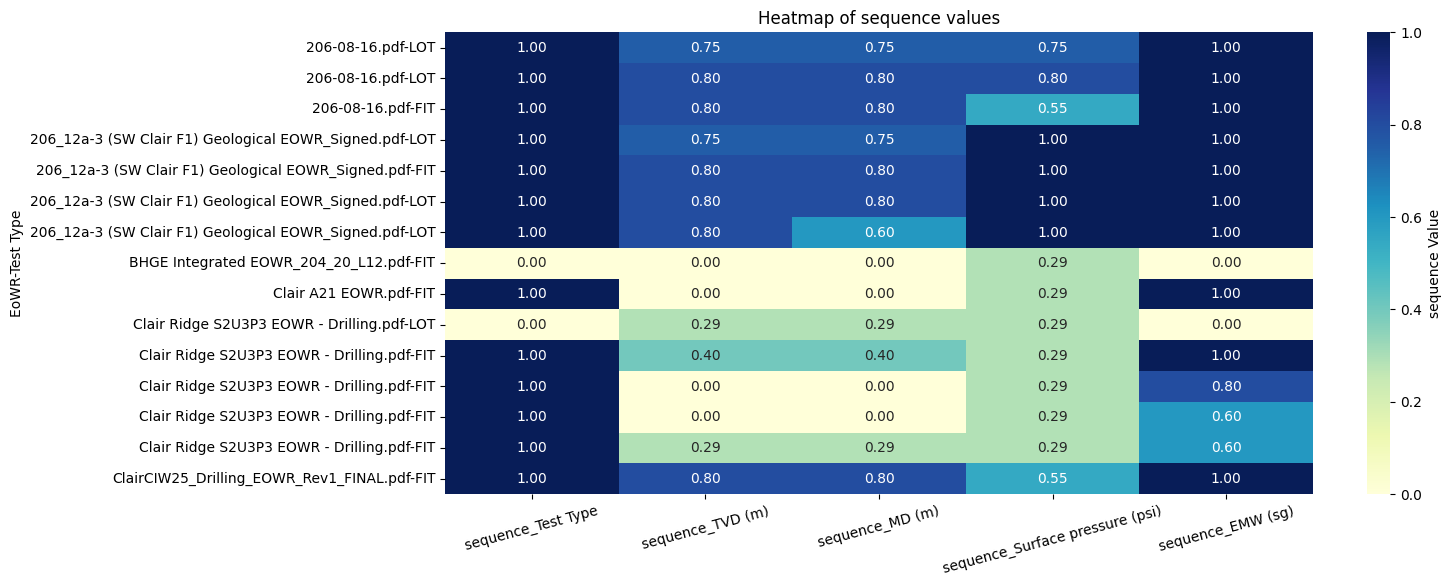

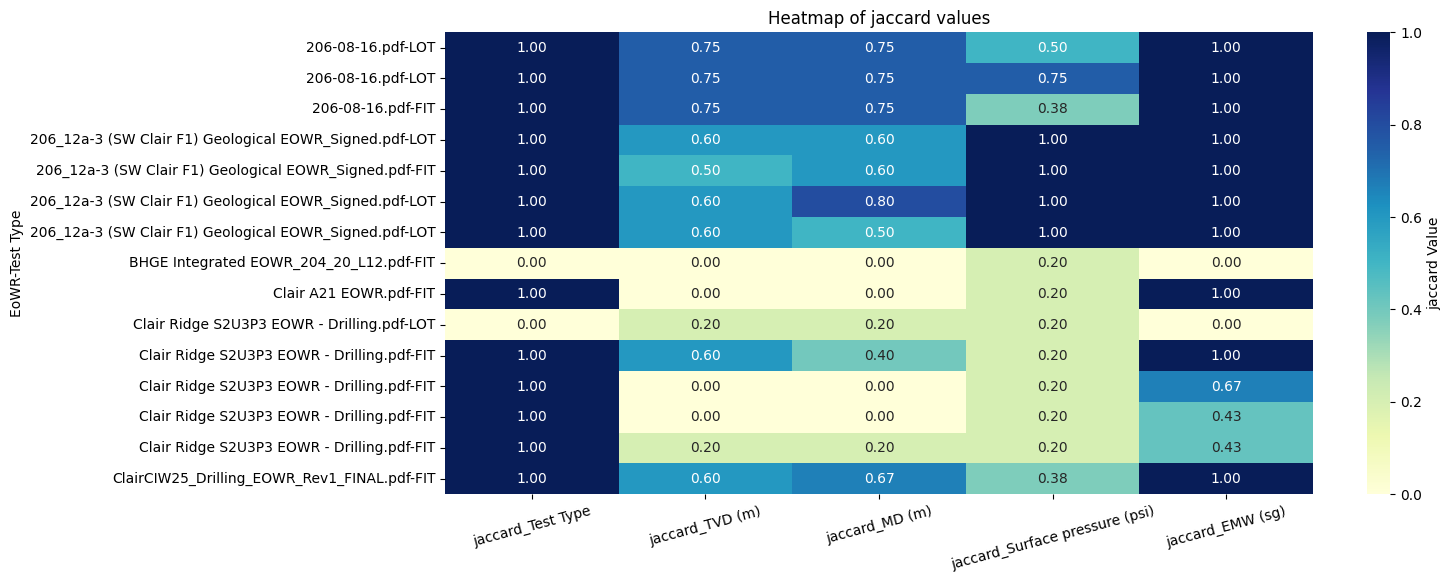

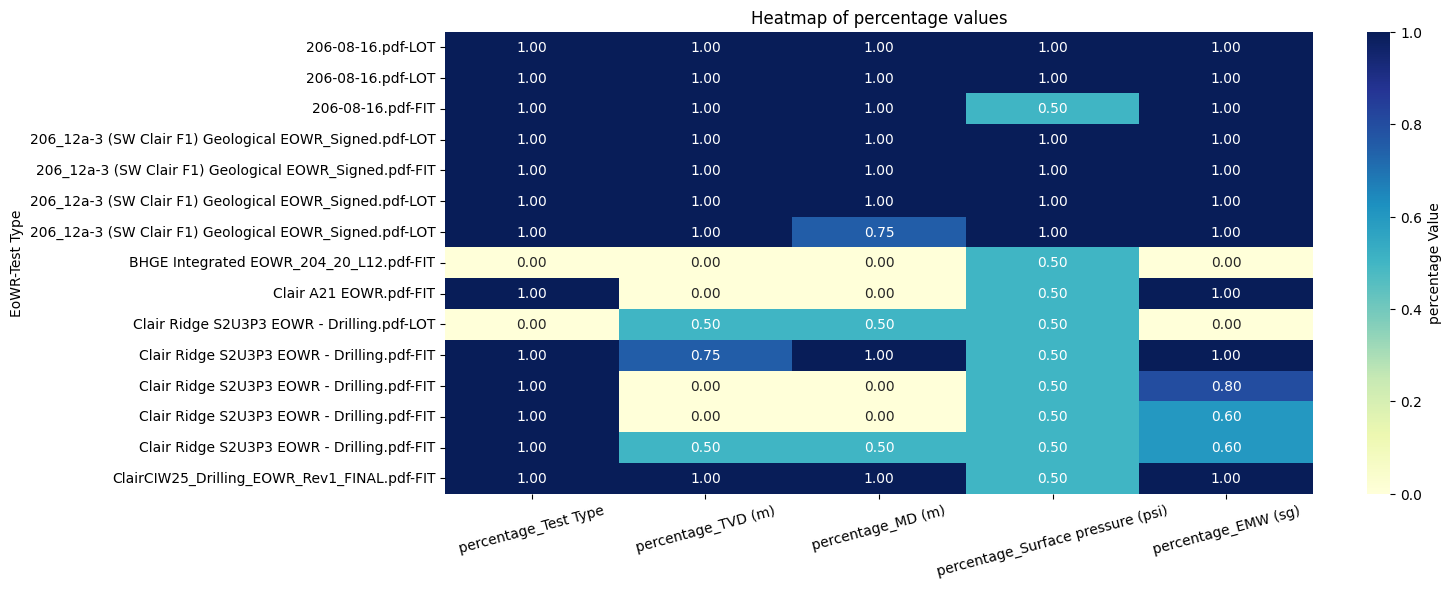

In [390]:
dfplot = result_df.copy()
performance_plot(dfplot)
dfplot = result_df.copy()
performance_plot(dfplot, "jaccard")
dfplot = result_df.copy()
performance_plot(dfplot, "percentage")